In [50]:
insert_animal = 'F'
inputEventTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_events.csv'
inputTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_trace.csv'
inputcelllocation = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/AN'+insert_animal+'Traces-props.csv'

In [56]:
import random
import numpy as np
import statistics 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
import scipy.signal 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from itertools import cycle
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

import matlab
import matlab.engine

#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '15'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '15'
mpl.rcParams['ytick.labelsize'] = '15'
mpl.rcParams['ytick.color'] = 'black'

data_event = pd.read_csv(inputEventTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
data_trace = pd.read_csv(inputTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
data_trace['unique_stage']=data_trace['stage']+data_trace['session'].astype(str)

def get_session(data_event_or_data_trace):
    """"get session takes the mega_event or trace file in and returns a list of all the session blocks
    INPUT:
    -------
    >> data_event_or_data_trace - mega_events OR mega_trace file
    
    OUTPUT:
    -------
    >> blocks - a list of all events or traces as in dataframe format """

    batches_dic = {'Exp1':1, 'Pre1':2, 'Nov1':3, 'Exp2':4, 'Pre2':5, 'Nov2':6, 'Exp3':7, 'Nov3':8}
    batches = list(set(data_event_or_data_trace.unique_stage))
    sorted_batches = []
    for i in batches:
        sorted_batches.append(batches_dic[i])
    sorted_batches.sort()

    batches = []
    for i in sorted_batches:
        batches.append(list(batches_dic.keys())[list(batches_dic.values()).index(i)])
    
    blocks = []
    for batch in batches:
        blocks.append(data_event_or_data_trace[data_event_or_data_trace['unique_stage']==batch])

    return blocks

traces = get_session(data_trace)
events = get_session(data_event)

In [60]:
sesh = 2
stranger = 2
## --------------------------------------------------------------------------------------------------
traces_session = traces[sesh]
events_session = events[sesh]

if sesh ==0 or sesh == 3 or sesh == 6:
    cells_dictionary = exp_all
elif sesh == 1 or sesh == 4:
    cells_dictionary = pre_all
else:
    cells_dictionary = nov_all

animal_cell_count = {'F':238, 'I':126, 'L':74}
all_cells = traces_session.iloc[: , 2:animal_cell_count[insert_animal]] #<---- (ANF - 238 cells, ANI - 126 cells, ANL - 74 cells)
cells_dictionary = traces_session.iloc[: , 2:animal_cell_count[insert_animal]].loc[:,~(traces_session==" nan").any()].columns.values
nan_cells = (set(all_cells.columns.values).difference(cells_dictionary))

data_trace = np.array(traces_session[cells_dictionary].astype(float)).transpose()

def trace_binning(spike_array, bin_size=10):
    bin_size = bin_size
    binned_spikes = []
    for neuron in spike_array:
        per_neuron=[]
        i=0
        while i <= len(neuron):
            per_neuron.append(np.mean(neuron[i:i+bin_size]))
            i+=bin_size
        binned_spikes.append(per_neuron)
    return binned_spikes

binned_data_trace = np.array(trace_binning(data_trace))

(182, 1199)

In [76]:
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/demos/python")
import readFloatsFile

# Add JIDT jar library to the path
jarLocation = "/Users/rufusmitchell-heggs/Desktop/infodynamics-dist-1.5/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
# startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

# # 0. Load/prepare the data:
# # dataRaw = readFloatsFile.readFloatsFile("/Users/rufusmitchell-heggs/Desktop/data/pfc/working_memory_package/Calcium_Output/data_trace_new2.csv")
# # As numpy array:

data = data_trace.transpose()

# data = numpy.array(dataRaw)
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
calc = calcClass()
# # 2. Set any properties to non-default values:
calc.setProperty("k", "3")

# # Compute for all pairs:
kraskov_mi_all = []
for s in range(len(data_trace)):
    mi = []
    for d in range(len(data_trace)):
        # For each source-dest pair:
# #         if (s == d):
# #             continue
        source = data[:, s]
        destination = data[:, d]

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.setObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()
        mi.append(result)
#         print("MI_Kraskov (KSG) alg. 2(col_%d -> col_%d) = %.4f nats" %
#             (s, d, result))
    kraskov_mi_all.append(mi)


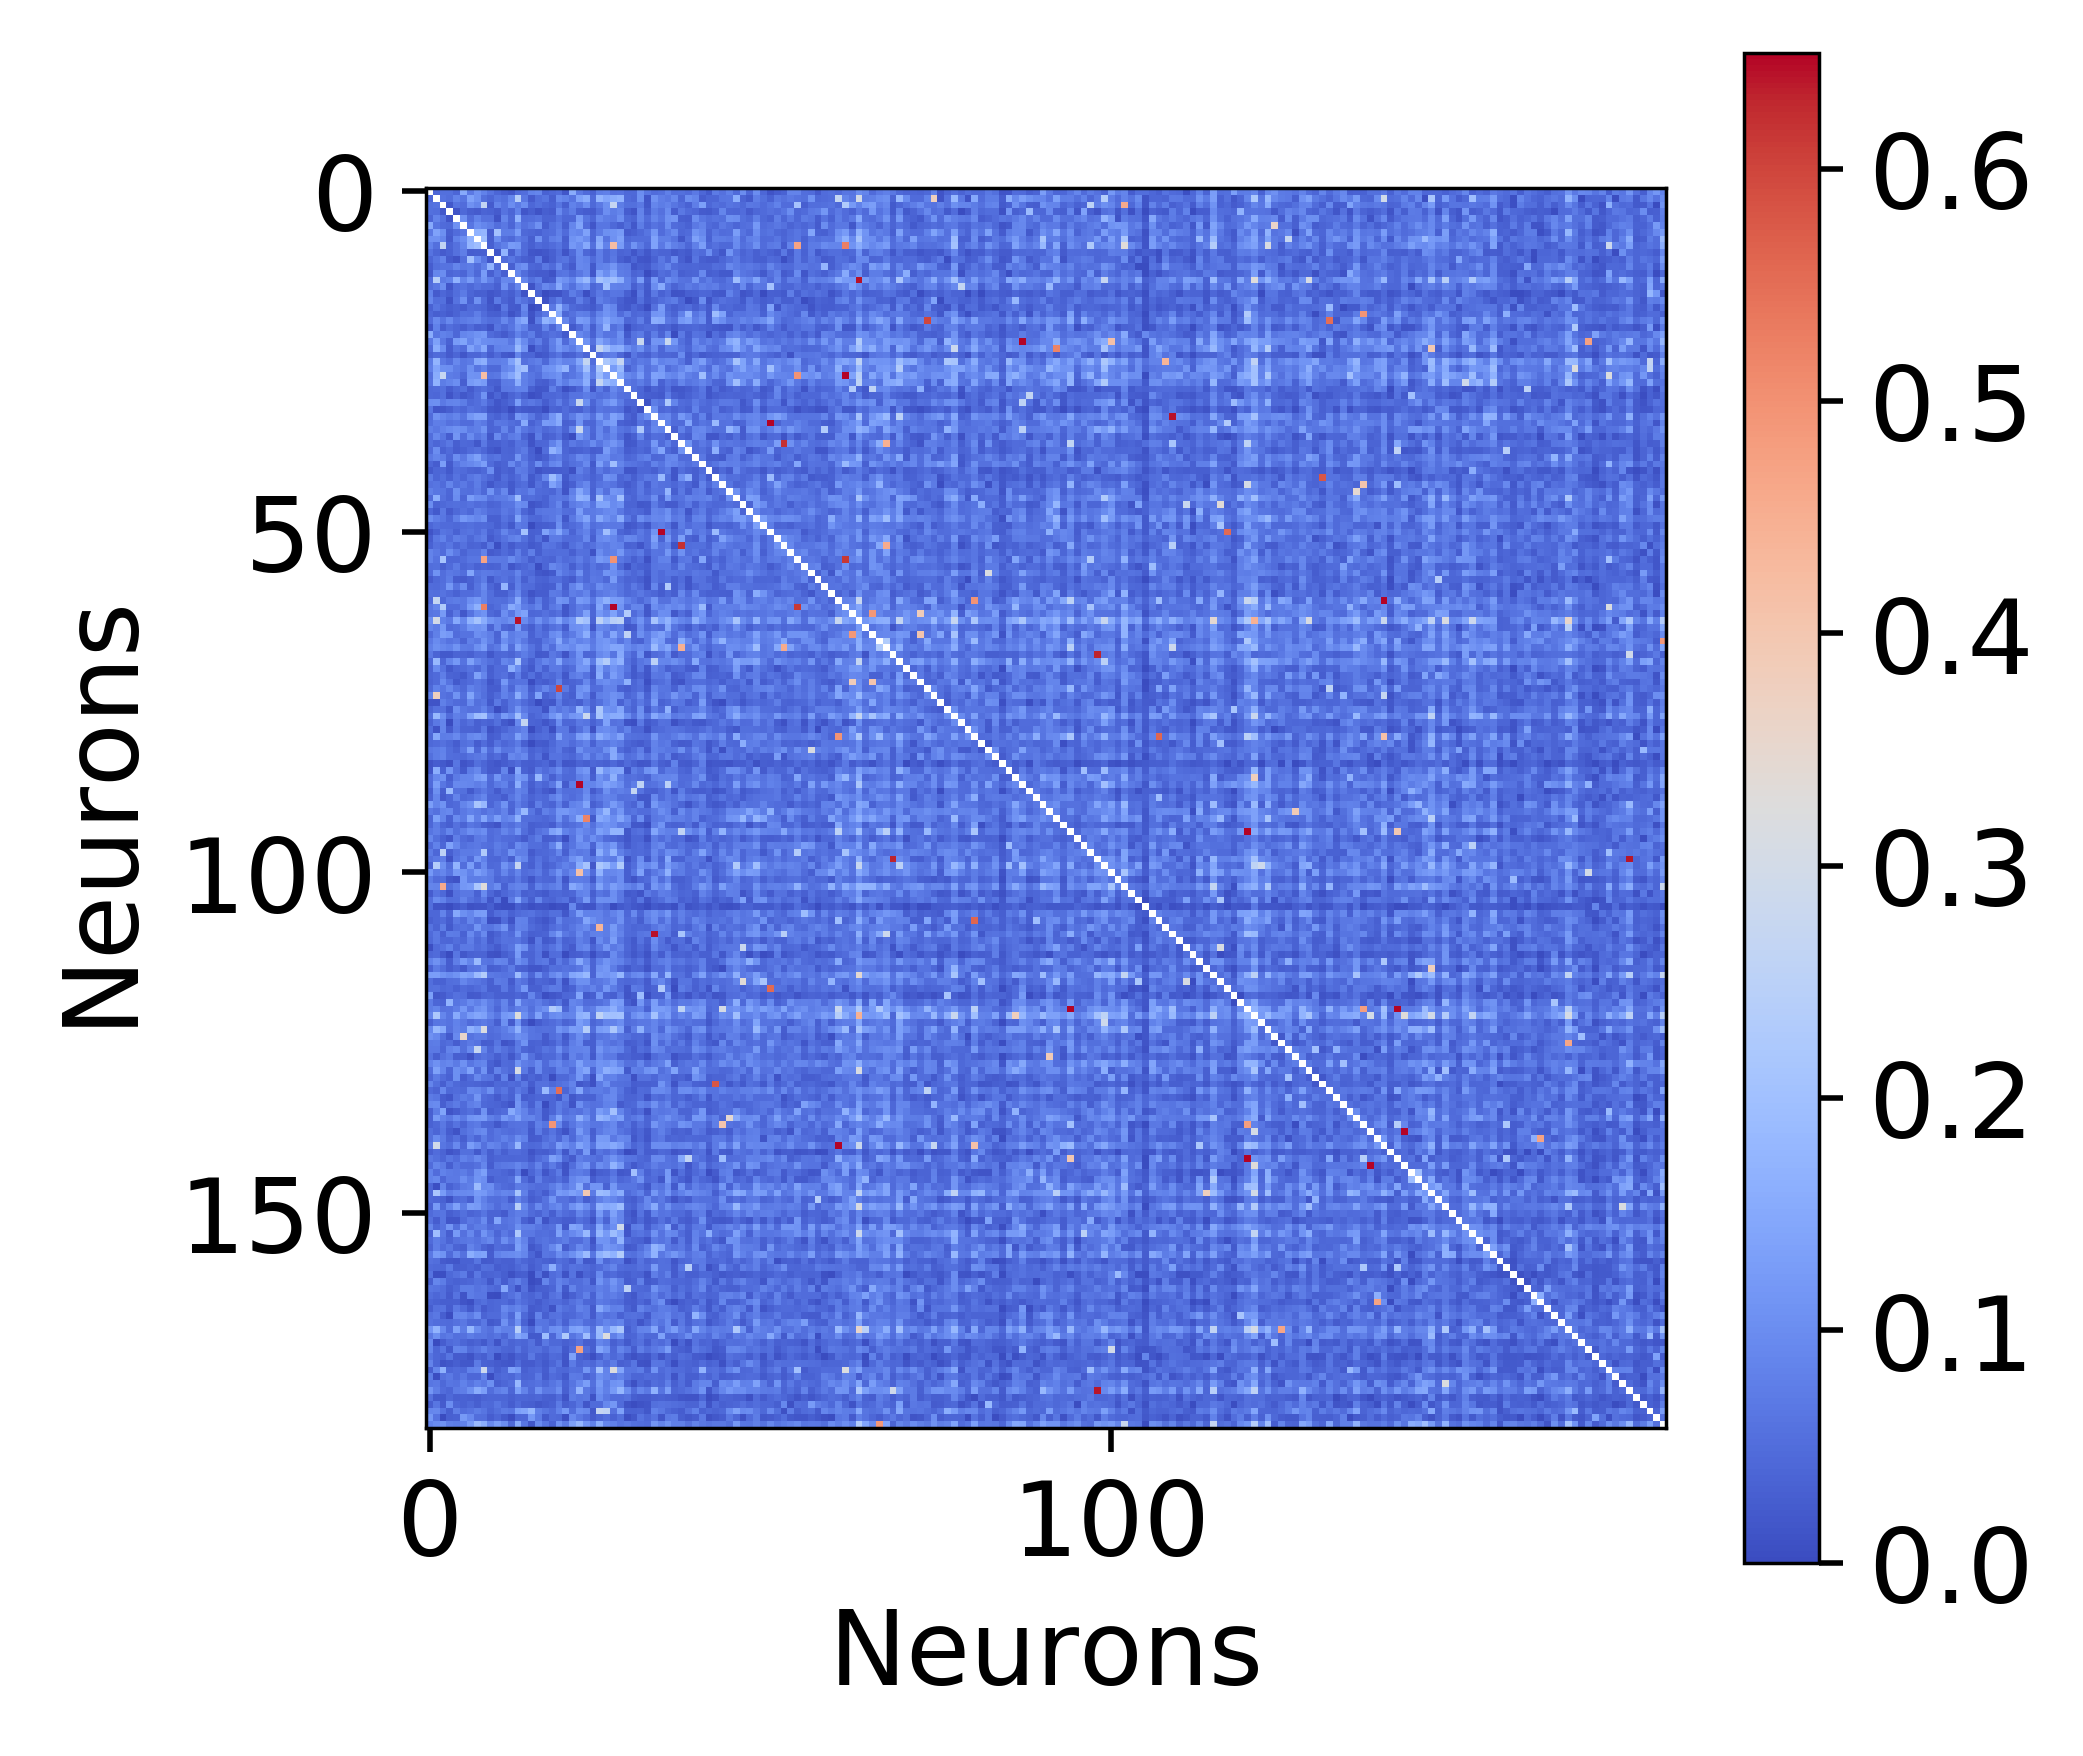

-0.012066048161116961
-0.00486841307296441
-0.0035874385092862556
-0.011502431682764384
-0.0009751590771549496
-0.0033353628347896343
-0.006273994728662147
-0.00037537344401949405
-0.006070167768269768
-0.002379092852802099
-0.0024073960239555095
-0.018872380047672662
-0.011666468720221162
-0.0028055778279350197
-0.0015501804597989257
-0.0026257780004081644
-0.006537296051211845
-0.005529905050876266
-0.007175298599935895
-0.005590937472626158
-0.0007514601275544304
-0.009247399578621864
-0.008890348327641118
-0.011402142462322596
-0.003921263460129868
-0.0035724268723862722
-0.0022648916959596547
-0.00236935369730508
-0.0019823516171562344
-0.006181637402606417
-0.0024092489529430063
-0.0027540469212787564
-3.044221588844391e-05
-0.003969386241536305
-0.014731223336842025
-0.0038830307859919044
-0.002700065669167222
-0.0033947888088026383
-0.00031816541102311255
-0.0014674640217719264
-0.00551754990570093
-0.011426933730649035
-0.0027575210691693284
-0.0023056590016738905
-0.000652454

In [81]:
mi_bits_all = math.log2(math.e) * np.array(kraskov_mi_all)
new_mi_bits_all = []
for i in mi_bits_all:
    new_mi = []
    for j in i:
        if j >1:
            new_mi.append(np.nan)
        else:
            new_mi.append(j)
    new_mi_bits_all.append(new_mi)
    
fig = plt.figure(figsize=(4, 4), dpi=500, facecolor='w', edgecolor='k')

plt.imshow(new_mi_bits_all, cmap="coolwarm", interpolation='nearest', vmin=0, vmax=0.65)
# plt.title("Neuron:Neuron Hamming distance over entire session")
plt.xlabel("Neurons" )
plt.ylabel("Neurons")
plt.yticks(rotation=0)
plt.colorbar()
plt.show()

for i in np.array(new_mi_bits_all).flatten():
    if i < 0:
        print(i)

In [91]:
data_events=np.array(events_session[cells_dictionary].astype(float)).transpose()
data_events_normalized = normalize(data_events, axis=1)

#--------------------------------------------------------------------------------------------------
#Create binary spike train
data_events_binarized = []
for neuron in range(len(data_events)):
    neuron_events_binarised = []
    for event in data_events[neuron]:
        if event > 0:
            neuron_events_binarised.append(1)
        else:
            neuron_events_binarised.append(0)
    data_events_binarized.append(neuron_events_binarised)
data_events_binarized = np.array(data_events_binarized)

def event_categorization(event_trace, bin_size = 0.25):
    """"Categorize all event traces into different bins of spike amplitudes.
    Due to low resolution, we can account for any lost spikes and weight events accordingly"""
    bin_size = bin_size #<---- must be greater than 0.25
    all_events = []
    data_events_categorised = []
    for neuron in range(len(event_trace)):
        neuron_events_categorised = []
        for event in event_trace[neuron]:
            if event > 0:
                if event < bin_size:
                    neuron_events_categorised.append(1)
                elif bin_size < event < (bin_size*2):
                    neuron_events_categorised.append(2)
                elif (bin_size*2) < event < (bin_size*3):
                    neuron_events_categorised.append(3)
                elif (bin_size*3) < event :
                    neuron_events_categorised.append(4)
            else:
                neuron_events_categorised.append(0)         
        data_events_categorised.append(neuron_events_categorised)
    return data_events_categorised

data_events_categorised = event_categorization(data_events_normalized, bin_size = 0.25)

#--------------------------------------------------------------------------------------------------
def spike_binning(spike_array, bin_size=10):
    bin_size = bin_size
    binned_spikes = []
    for neuron in spike_array:
        per_neuron=[]
        i=0
        while i <= len(neuron):
            per_neuron.append(sum(neuron[i:i+bin_size]))
            i+=bin_size
        binned_spikes.append(per_neuron)
    return binned_spikes

binned_data_events_binarized = np.array(spike_binning(data_events_binarized))
binned_data_events_categorised = np.array(spike_binning(data_events_categorised))

empty = []
empty_binary = []
for i in range(len(binned_data_events_categorised)):
    if sum(binned_data_events_categorised[i]) == 0:
        empty.append(i)
        
binned_data_events_categorised = np.delete(binned_data_events_categorised, empty, 0).transpose()
binned_data_events_binarized = np.delete(binned_data_events_binarized, empty_binary, 0).transpose()

cells_dictionary = np.delete(cells_dictionary, empty, 0)

binned_data_events_categorised = binned_data_events_categorised.transpose()
binned_data_events_binarized = binned_data_events_binarized.transpose()
#--------------------------------------------------------------------------------------------------
entropies=[]
for neuron in range(len(binned_data_events_categorised)): 
    #Define probability of each neuron firing
    count_individ_dic = {0:0, 1:0}
    for spike in binned_data_events_categorised[neuron]:
        spike_count_entry = int(spike)
        if spike_count_entry > 0:
            count_individ_dic[1] += spike*1
        else:
            count_individ_dic[0] += 1 

    probability_response_dic = {}
    for key in count_individ_dic:
        probability_response_dic[key] = count_individ_dic[key]/sum(count_individ_dic.values())

    #define entropy for every neuron
    entropyr = 0
    for key in probability_response_dic:
        entropyr += -(probability_response_dic[key]*math.log2(probability_response_dic[key]))
    entropies.append(entropyr)
#--------------------------------------------------------------------------------------------------

#Joint entropies
mi_all = []
mutual_info_dis_all = []
for neuron1 in range(len(binned_data_events_categorised)):
    mutual_info_dis = []
    mi = []
    for neuron2 in range(len(binned_data_events_categorised)):
        #intialise count__spike_behav_dic
        count__spike_spike_dic = {'count00':0,'count01':0,'count10':0, 'count11':0}
        #How many spikes are there during each behaviour
        for spikei, spikej in zip(binned_data_events_categorised[neuron1], binned_data_events_categorised[neuron2]):                     
                if int(spikei) > int(spikej):
                    count__spike_spike_dic['count11'] += spikej*1
                    count__spike_spike_dic['count10'] += int(spikei-spikej)*1
                elif int(spikei) < int(spikej):
                    count__spike_spike_dic['count11'] += spikei*1
                    count__spike_spike_dic['count01'] += int(spikej-spikei)*1
                elif int(spikei) == int(spikej) and spikei >0:
                    count__spike_spike_dic['count11'] += spikei*1
                else:
                    count__spike_spike_dic['count00'] += 1
        #What is the probability of that spike during the behaviour
        probability_spike_spike_dic = {}         
        for key in count__spike_spike_dic:
            probability_spike_spike_dic[key] = count__spike_spike_dic[key]/sum(count__spike_spike_dic.values())

        entropy_spike_spike_dic = {}         
        for key in probability_spike_spike_dic:
            if probability_spike_spike_dic[key] > 0:
                entropy_spike_spike_dic[key] = probability_spike_spike_dic[key]*math.log2(1/probability_spike_spike_dic[key])
            else:
                entropy_spike_spike_dic[key] = 0
        j_entropy = sum(entropy_spike_spike_dic.values())
        if neuron1 != neuron2:
            mutual_info = entropies[neuron1] + entropies[neuron2] - j_entropy
        else:
            mutual_info = np.nan
        mi.append(mutual_info)
        mutual_info_dis.append(1-(mutual_info/j_entropy))
    mi_all.append(mi)
    mutual_info_dis_all.append(mutual_info_dis)
#--------------------------------------------------------------------------------------------------

mutual_info_dis_all = np.array(mutual_info_dis_all)
mi_all = np.array(mi_all)

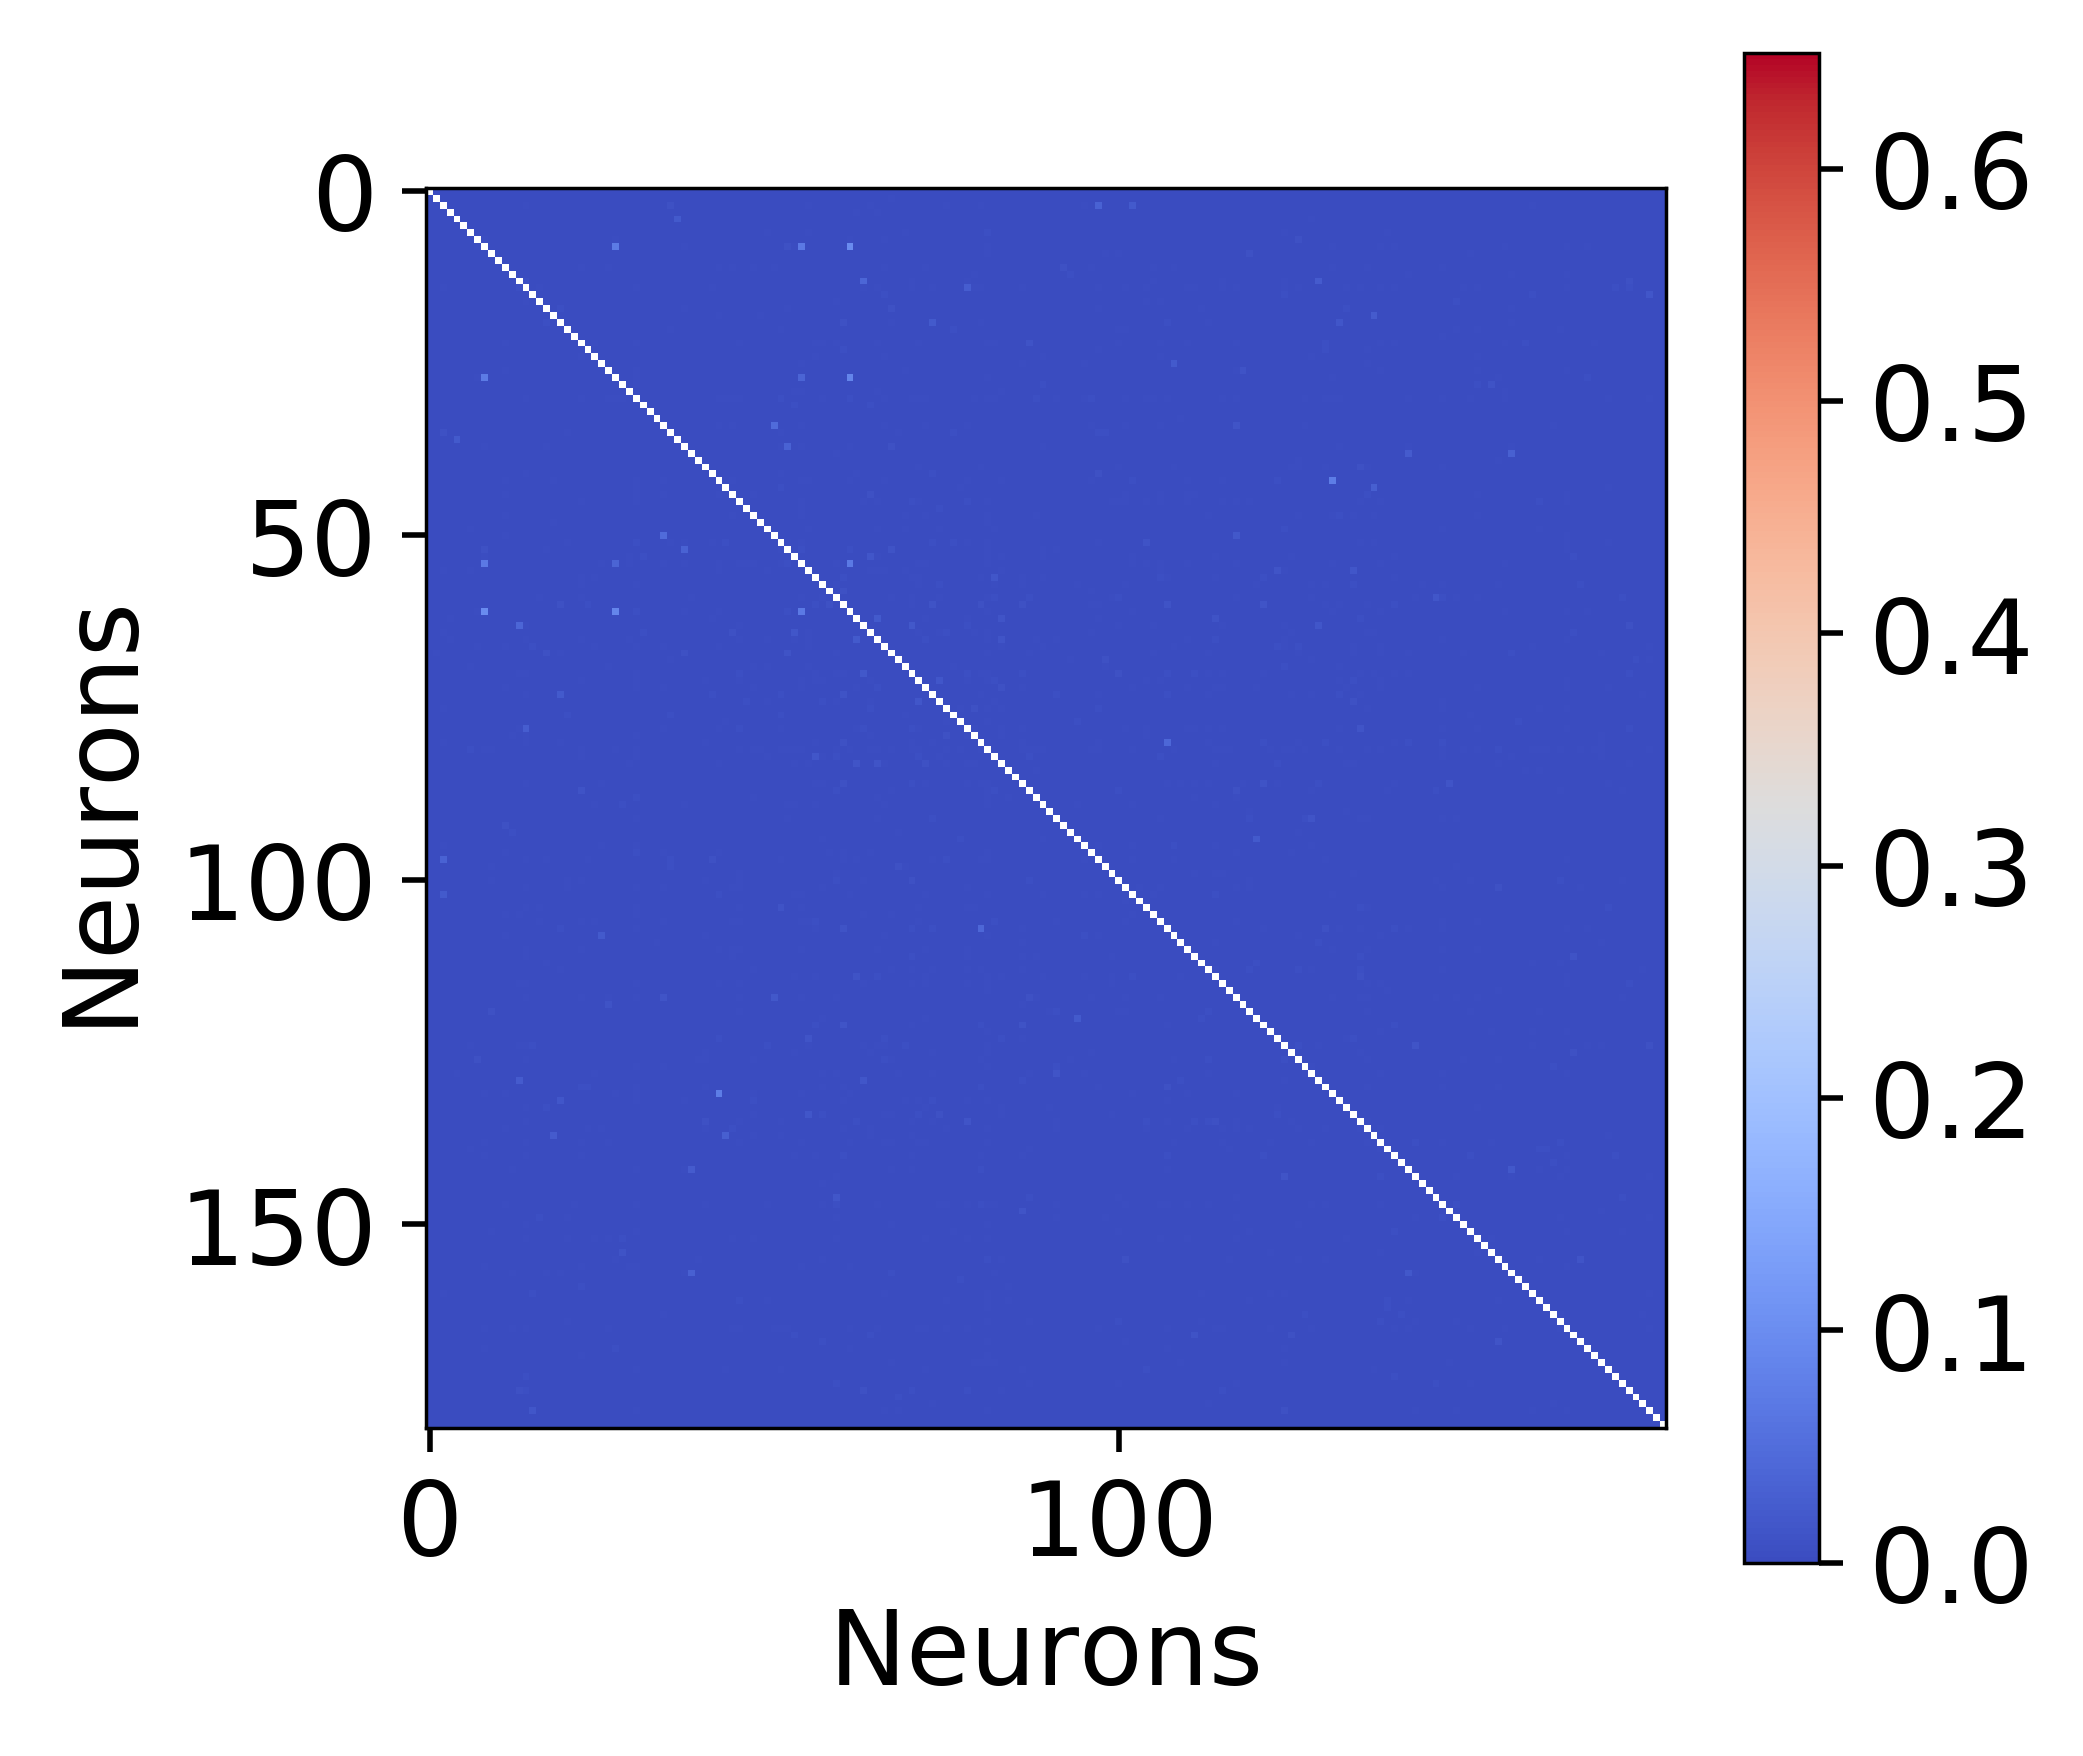

In [92]:
fig = plt.figure(figsize=(4, 4), dpi=500, facecolor='w', edgecolor='k')

plt.imshow(mi_all, cmap="coolwarm", interpolation='nearest', vmin=0, vmax=0.65)
# plt.title("Neuron:Neuron Hamming distance over entire session")
plt.xlabel("Neurons" )
plt.ylabel("Neurons")
plt.yticks(rotation=0)
plt.colorbar()
plt.show()

0.0013613301602420772
0.06729934568050584


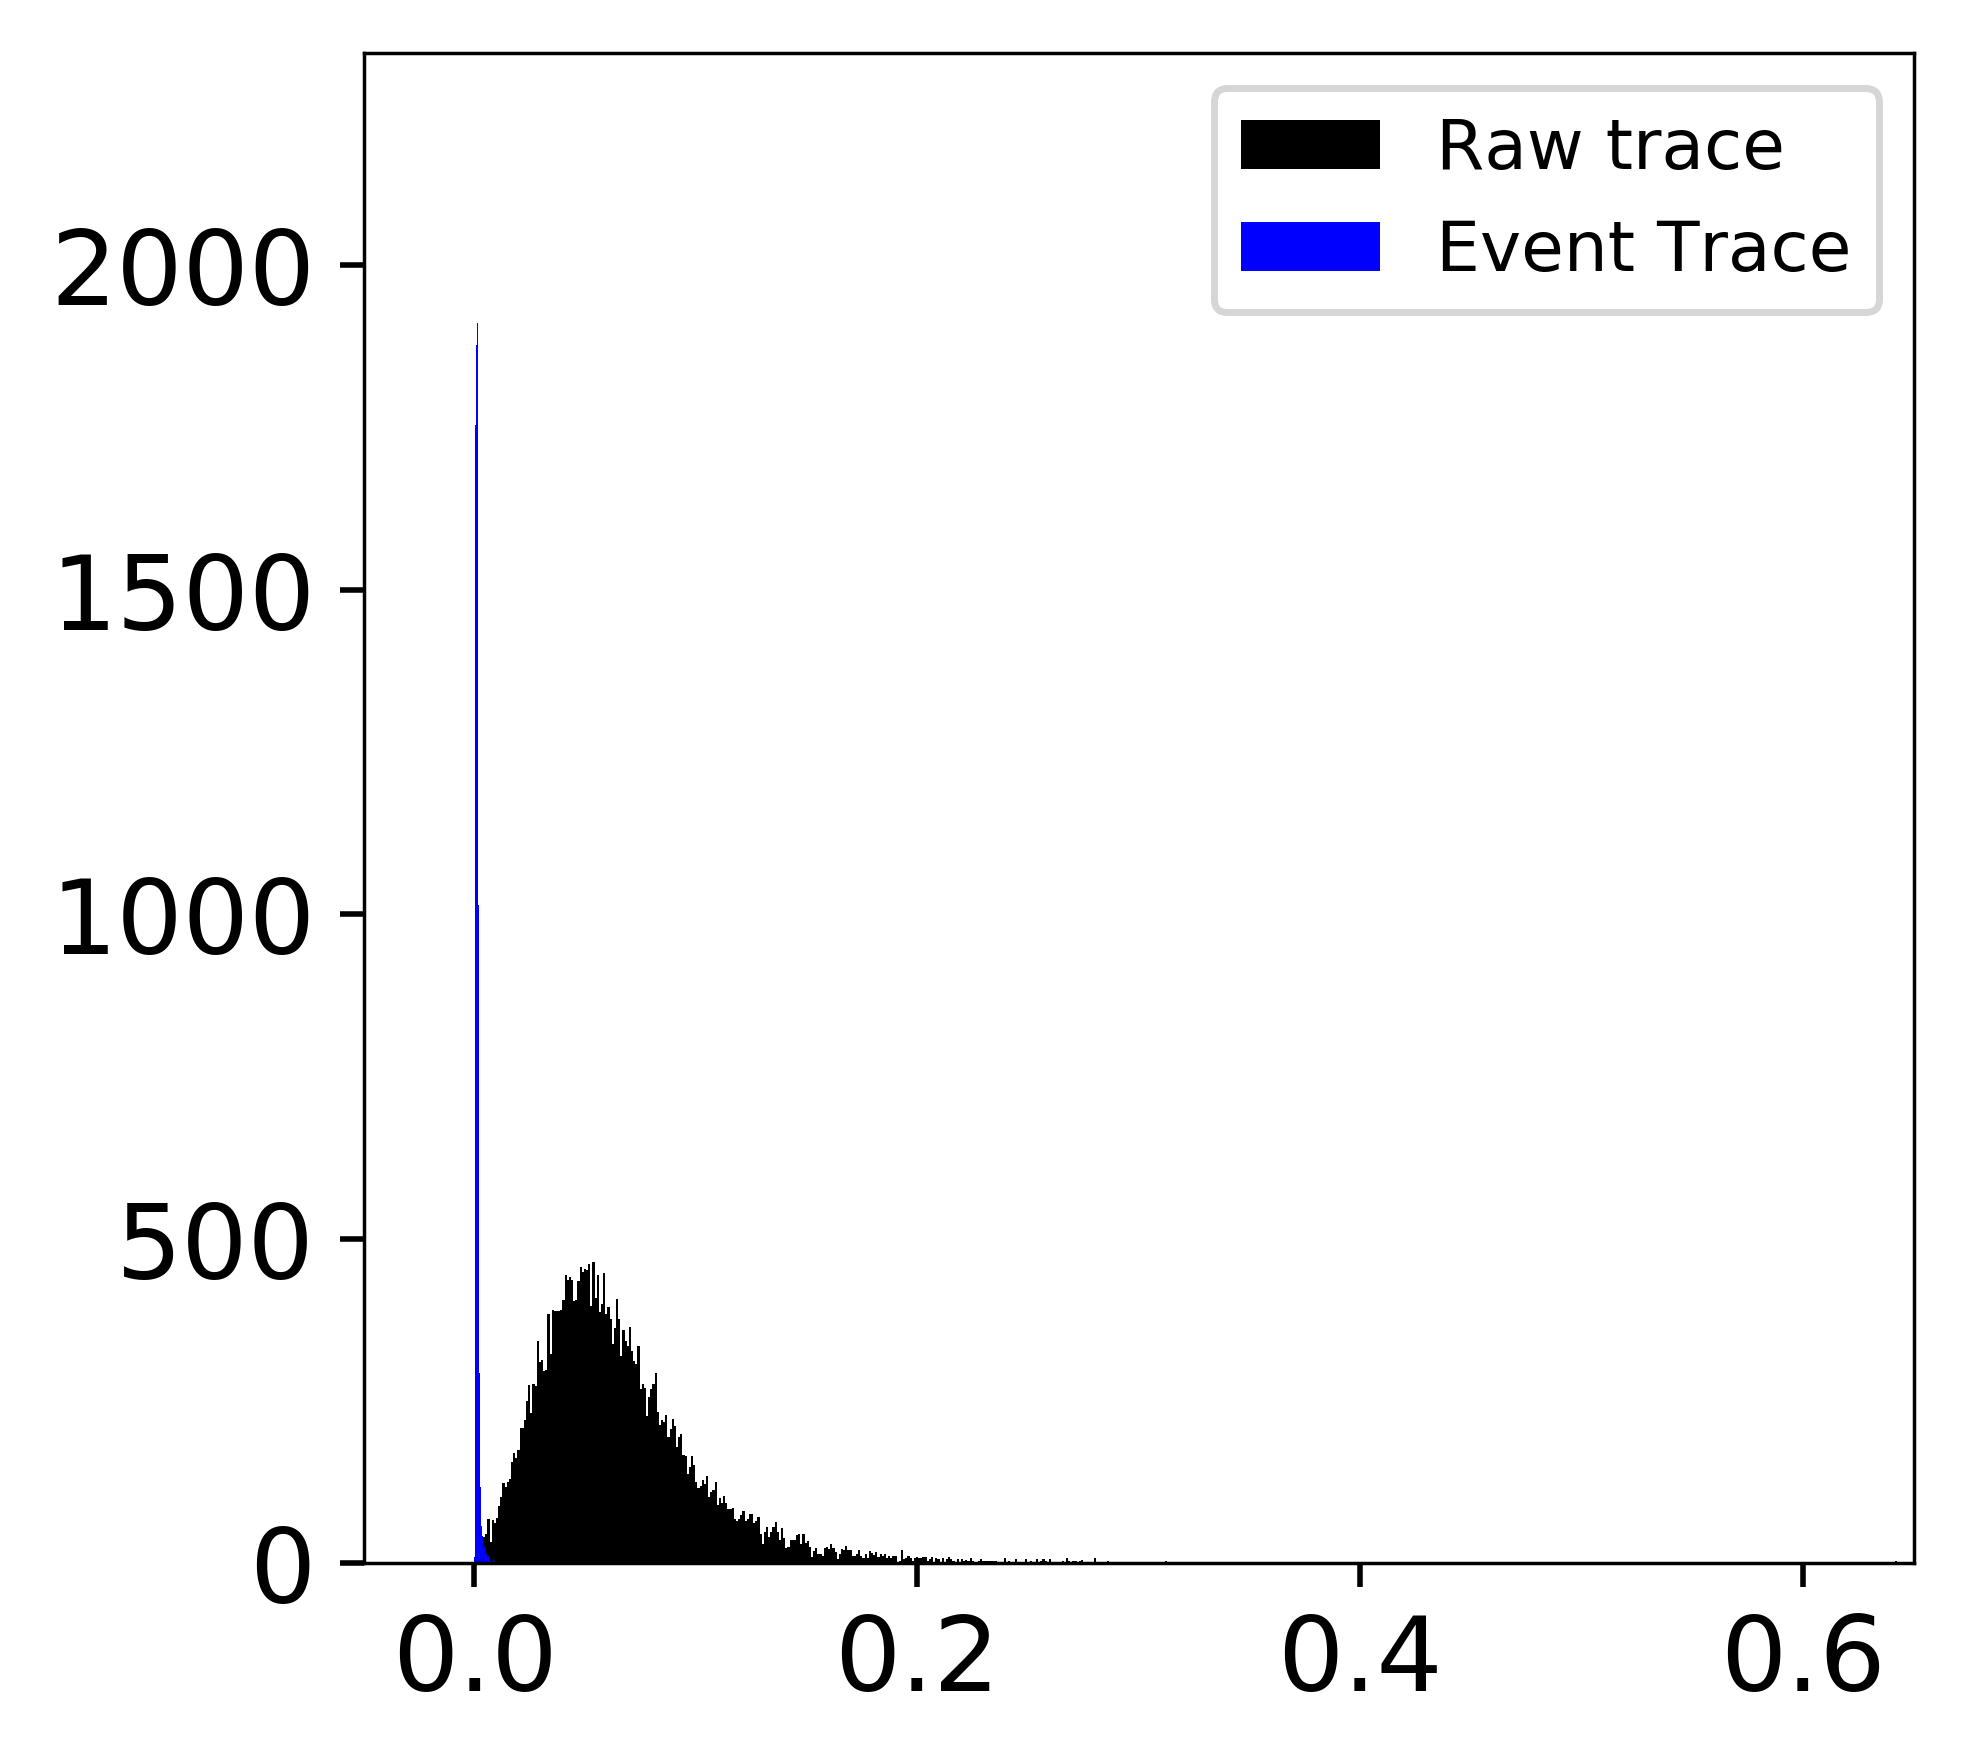

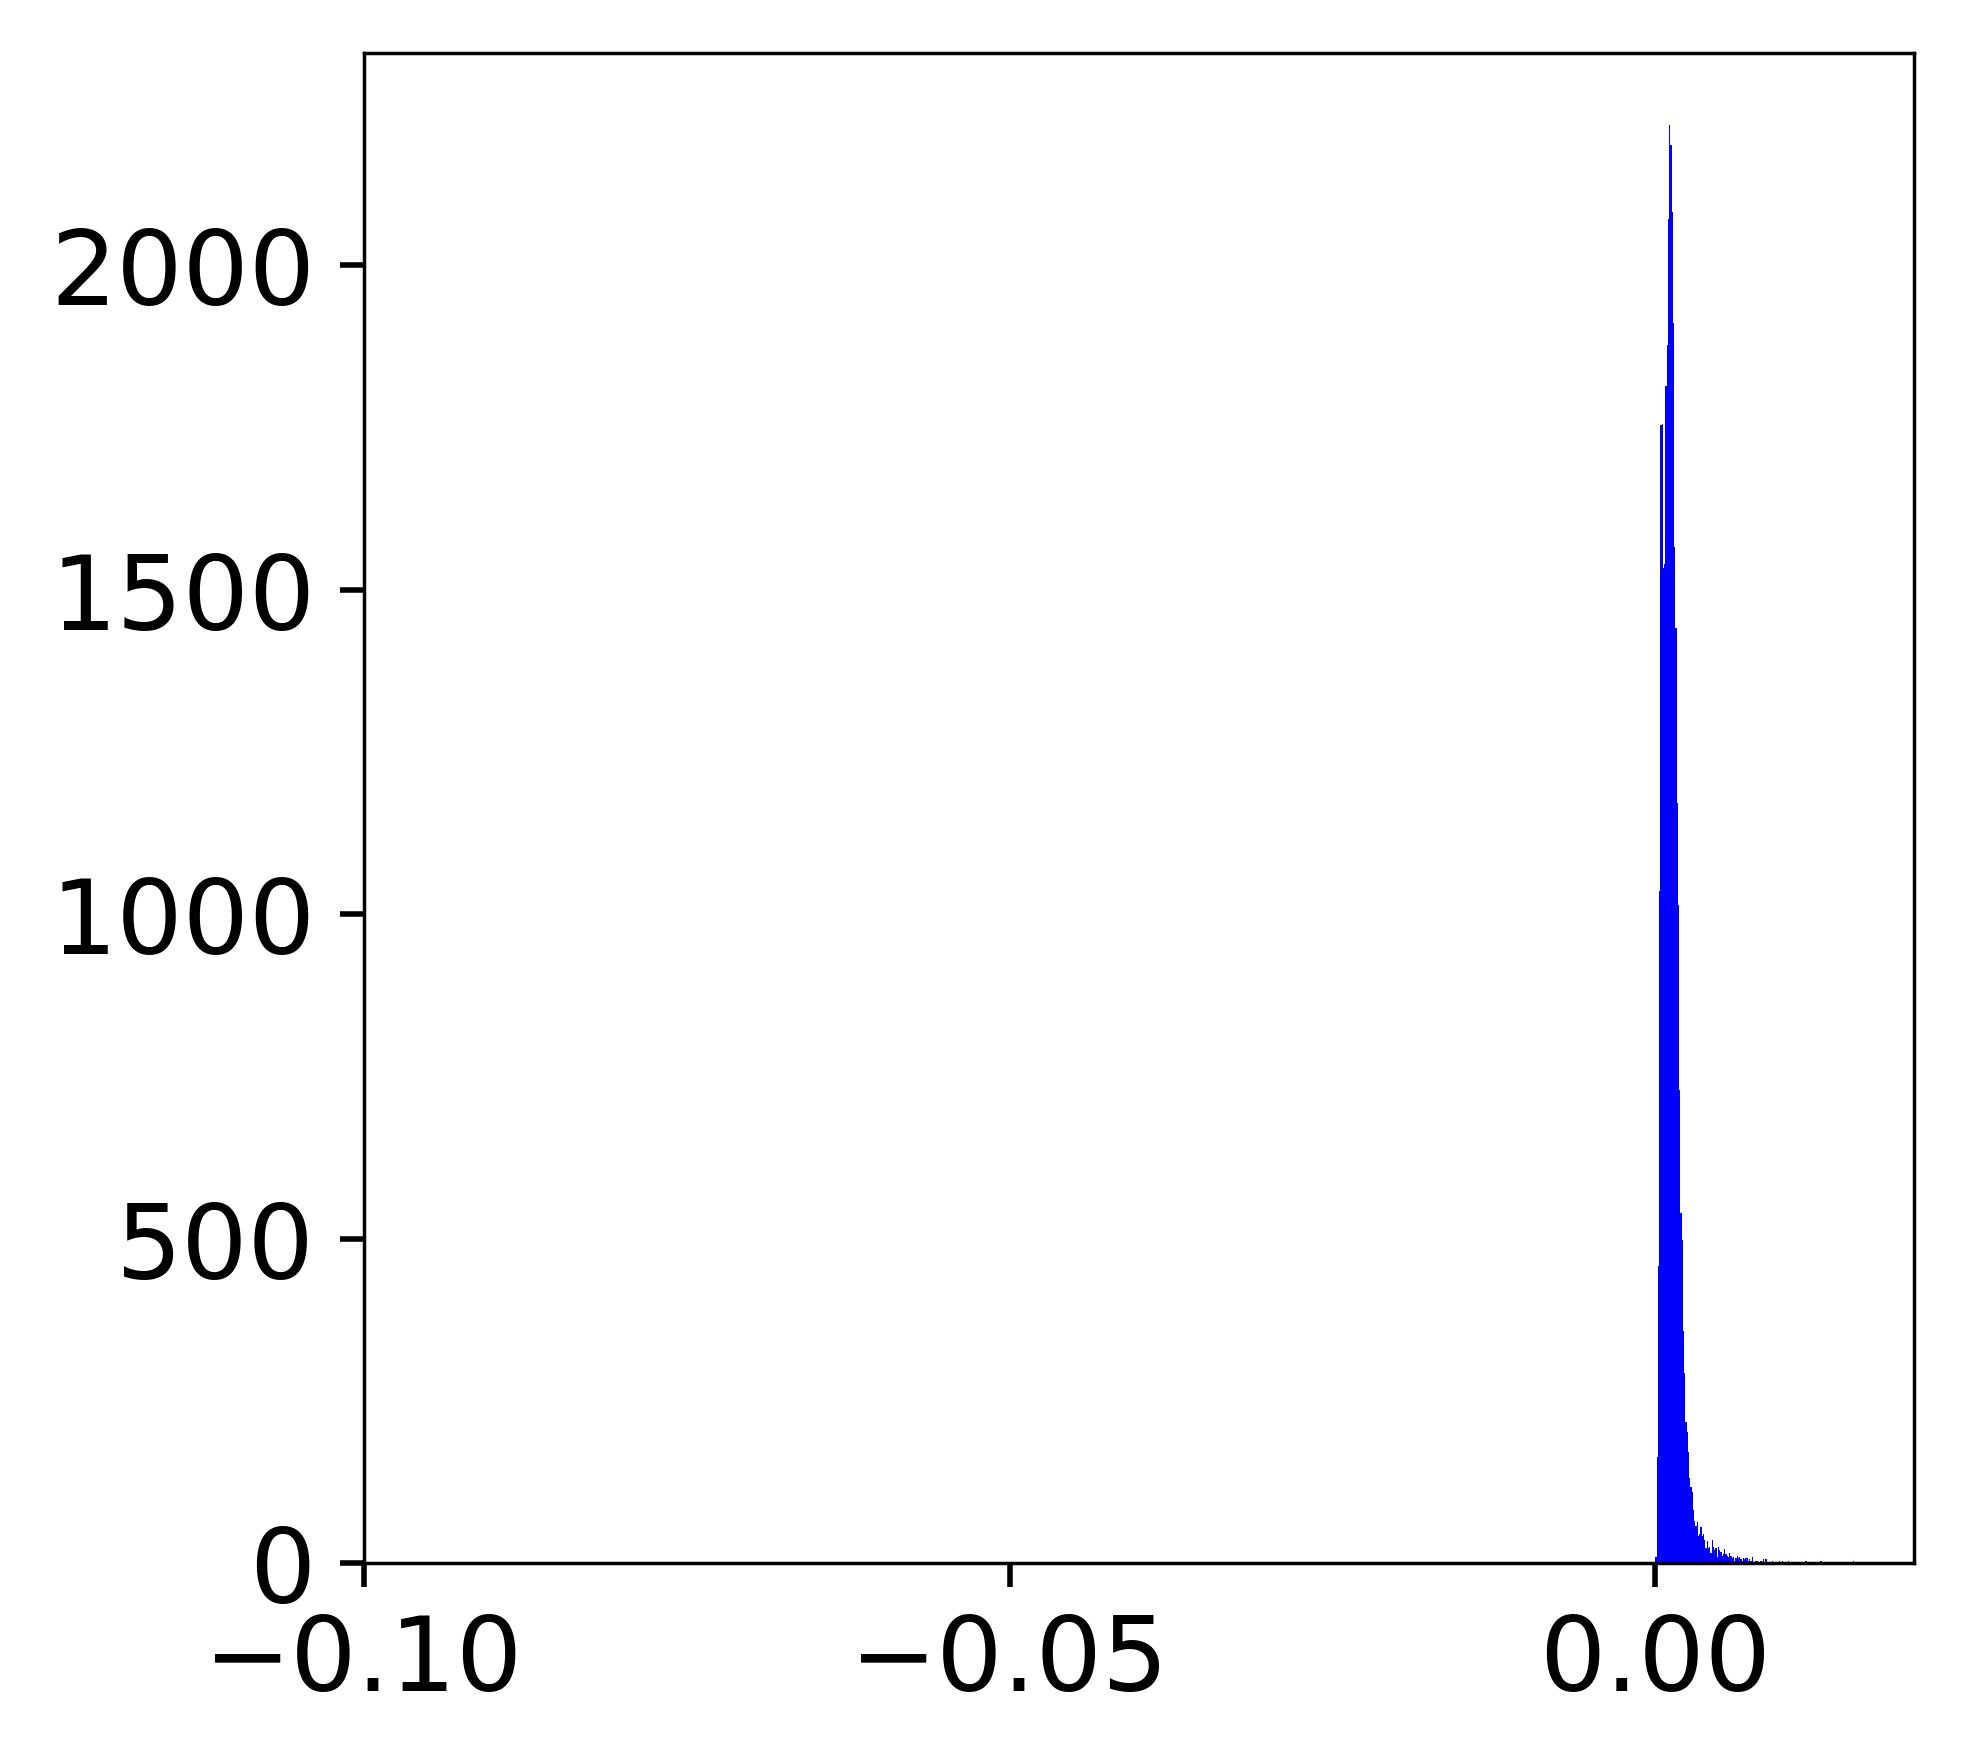

In [110]:
print(np.nanmean(mi_all))
print(np.nanmean(new_mi_bits_all))


kraskov = np.array(new_mi_bits_all).flatten()
kraskov = kraskov[~numpy.isnan(kraskov)]
kraskov_new = []
for i in kraskov:
    if i > 0:
        kraskov_new.append(i)
        
mi_old = np.array(mi_all).flatten()
mi_old = mi_old[~numpy.isnan(mi_old)]

fig = plt.figure(figsize=(4, 4), dpi=500, facecolor='w', edgecolor='k')

plt.hist(kraskov_new, bins=1000, color='black')
plt.hist(mi_old, bins=1000, color='blue')
plt.xlim(-0.05,0.65)
plt.legend(['Raw trace', 'Event Trace'])
plt.show()
fig = plt.figure(figsize=(4, 4), dpi=500, facecolor='w', edgecolor='k')

plt.hist(mi_old, bins=1000, color='blue')
plt.xlim(-0.1,0.02)
plt.show()
